In [1]:
import pandas as pd
import os
from sklearn.manifold import MDS
from sklearn.metrics import euclidean_distances
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
# access word2vec representations of certain words in a list
from gensim.models import KeyedVectors
import numpy as np

# Leuven

In [4]:
leuven_dir = '/Users/siddharthsuresh/Documents/LeuvenNorms/'
animal_norms_og = pd.read_csv(os.path.join(leuven_dir,'ANIMALSexemplarfeaturesbig.txt'), sep = "\t")
# animal_norms = pd.read_csv(os.path.join(leuven_dir,'ANIMALSexemplarfeaturesbig.txt'), sep=" ", header=None)

In [5]:
# select all columns except 'Ffrq' and 'feature/_exemplar_ENGLISH'
animal_norms = animal_norms_og.iloc[:, 2:]

# multiply each row in animal norms by each row in animal_norms_og['FFrq'] and divide by sum of animal_norms_og['FFrq'] 
animal_norms = animal_norms.iloc[:,1:].multiply(animal_norms_og['FFrq'], axis=0).divide(animal_norms_og['FFrq'].sum(), axis=0)
#switch rows and columns
animal_norms_transformed = animal_norms.T

# do mds on the animal norms and find the optimal number of dimensions

def mds_on_animal_norms(animal_norms):
    # get the euclidean distance matrix
    dist = euclidean_distances(animal_norms)
    # do mds on the distance matrix
    mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
    pos = mds.fit_transform(dist)
    return pos

#write a function to plot mds results and label each point by the animal name

def plot_mds(pos, animal_names):
    xs, ys = pos[:, 0], pos[:, 1]
    plt.figure(figsize=(20, 20))
    plt.scatter(xs, ys, marker='o')
    for x, y, name in zip(xs, ys, animal_names):
        plt.text(x, y, name)
    plt.show()


def load_word2vec_model():
    model = KeyedVectors.load_word2vec_format('/Users/siddharthsuresh/gensim-data/word2vec-google-news-300/word2vec-google-news-300', binary=True)
    return model


def get_word2vec(word_list):
    # load the word2vec model
    model = KeyedVectors.load_word2vec_format('/Users/siddharthsuresh/gensim-data/word2vec-google-news-300/word2vec-google-news-300', binary=True)
    # get the word2vec representations of the words in the list
    word_vectors = [model[word] for word in word_list]

    # convert the list of word2vec representations to a numpy array
    word_vectors = np.array(word_vectors)
    return word_vectors

def get_words_common_to_word2vec_and_leuven(word_list, word2vec_model):
    word2vec_words = word2vec_model.index_to_key
    common_words = set(word_list).intersection(word2vec_model.index_to_key)
    return common_words


In [4]:
model = load_word2vec_model()
animal_names = animal_norms_transformed.index
common_words = get_words_common_to_word2vec_and_leuven(animal_names, model)
animal_norms_transformed = animal_norms_transformed.loc[common_words]

/var/folders/qt/rt9bv7zs62b05gjym3zzqgyw0000gn/T/ipykernel_61857/3091698759.py:4: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  animal_norms_transformed = animal_norms_transformed.loc[common_words]


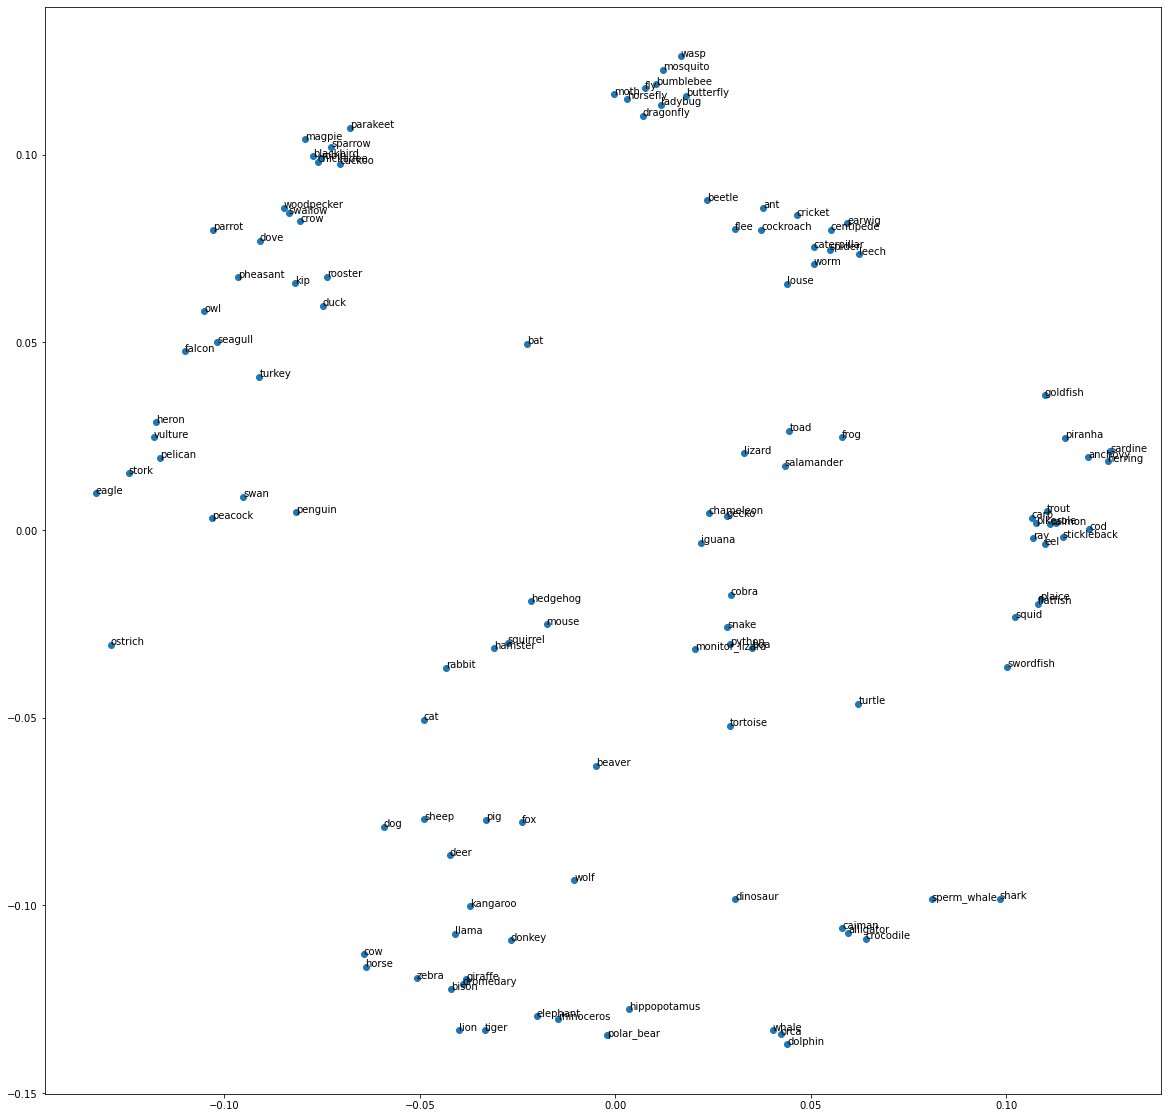

In [5]:
leuven_pos = mds_on_animal_norms(animal_norms_transformed)
plot_mds(leuven_pos, common_words)
# print(leuven_pos.shape, len(common_words))

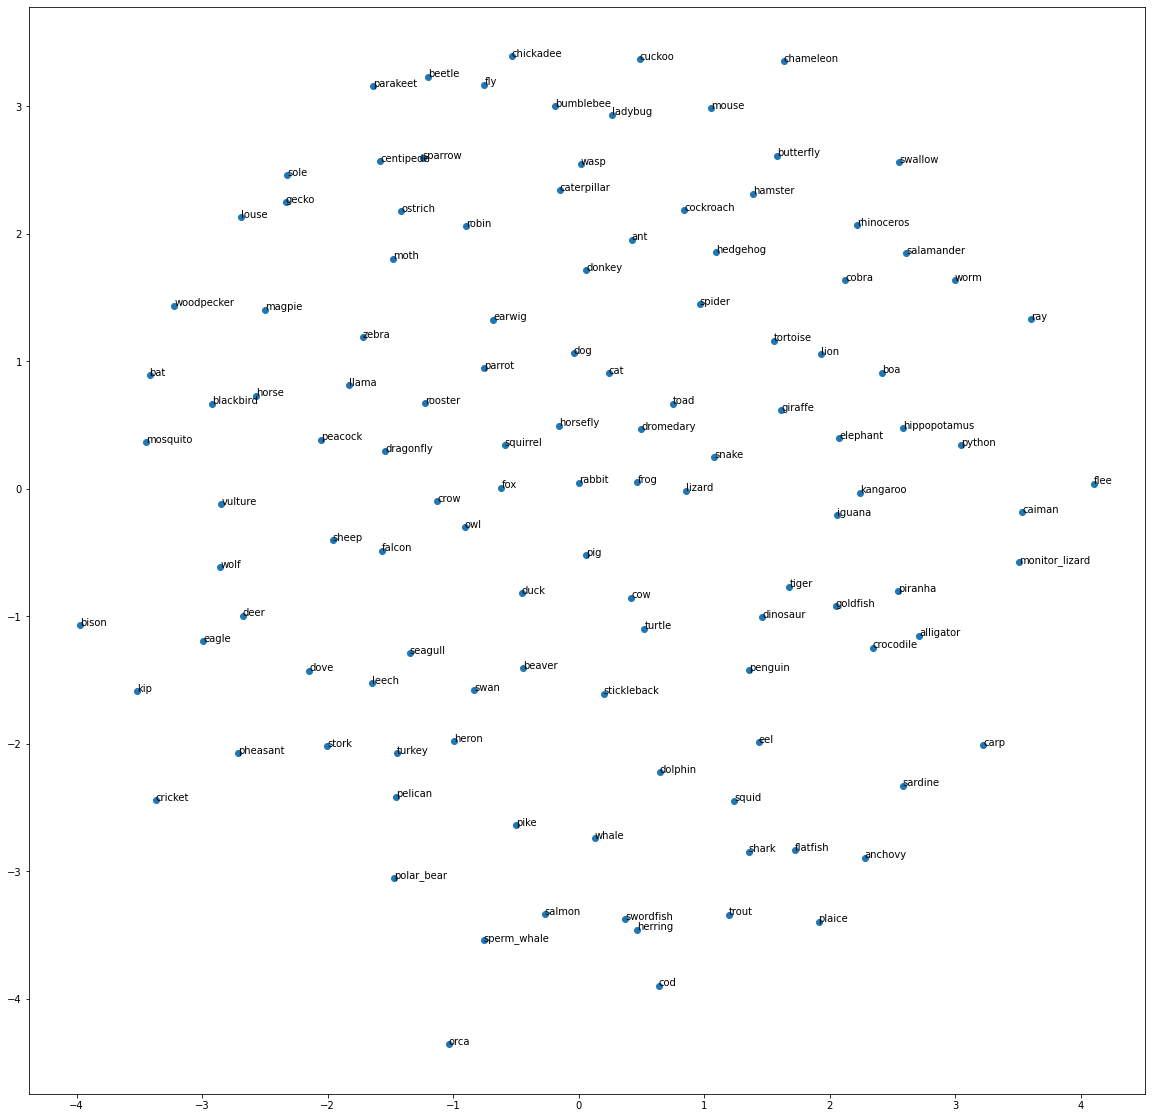

In [7]:
word2vec_animals = get_word2vec(common_words)
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
# word2vec_pos = mds.fit_transform(word2vec_animals)
word2vec_pos = mds_on_animal_norms(word2vec_animals)
plot_mds(word2vec_pos, common_words)


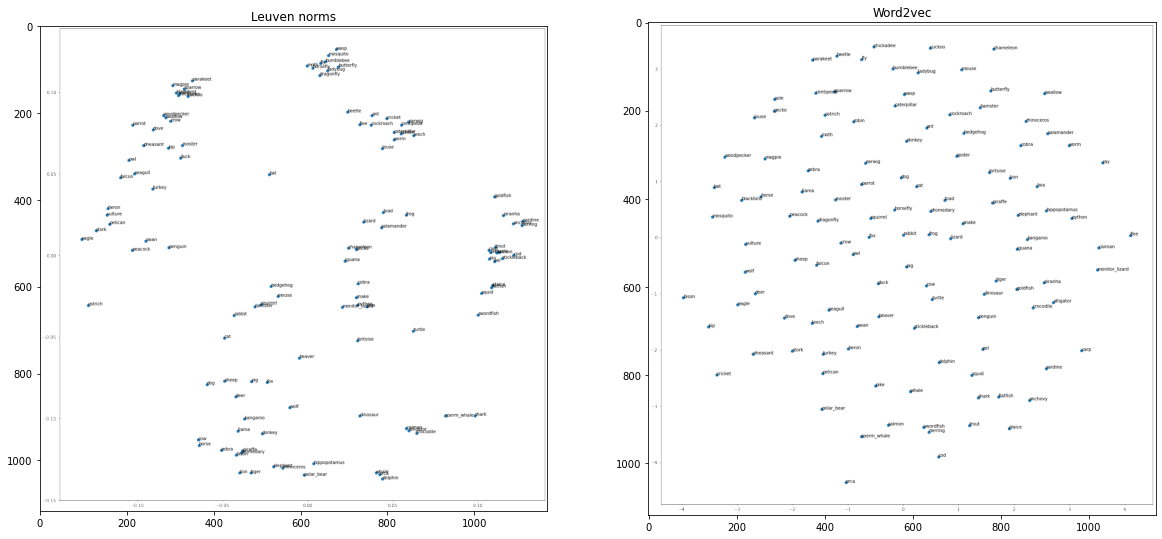

In [3]:
img_1 = '/Users/siddharthsuresh/Downloads/word2vec.png'
img_2 = '/Users/siddharthsuresh/Downloads/leuven.png'

# Plot img_1 and img_2 side by side using matplot lib. Set the title of img_1 as 'Leuven norms' and img_2 as 'Word2vec'. Use high dpi to make the images look clear.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 20))
ax1.imshow(plt.imread(img_2))
ax1.set_title('Leuven norms')
ax2.imshow(plt.imread(img_1))
ax2.set_title('Word2vec')
plt.savefig("/Users/siddharthsuresh/Downloads/leuven_w2v.jpg", dpi=1200)
plt.show()






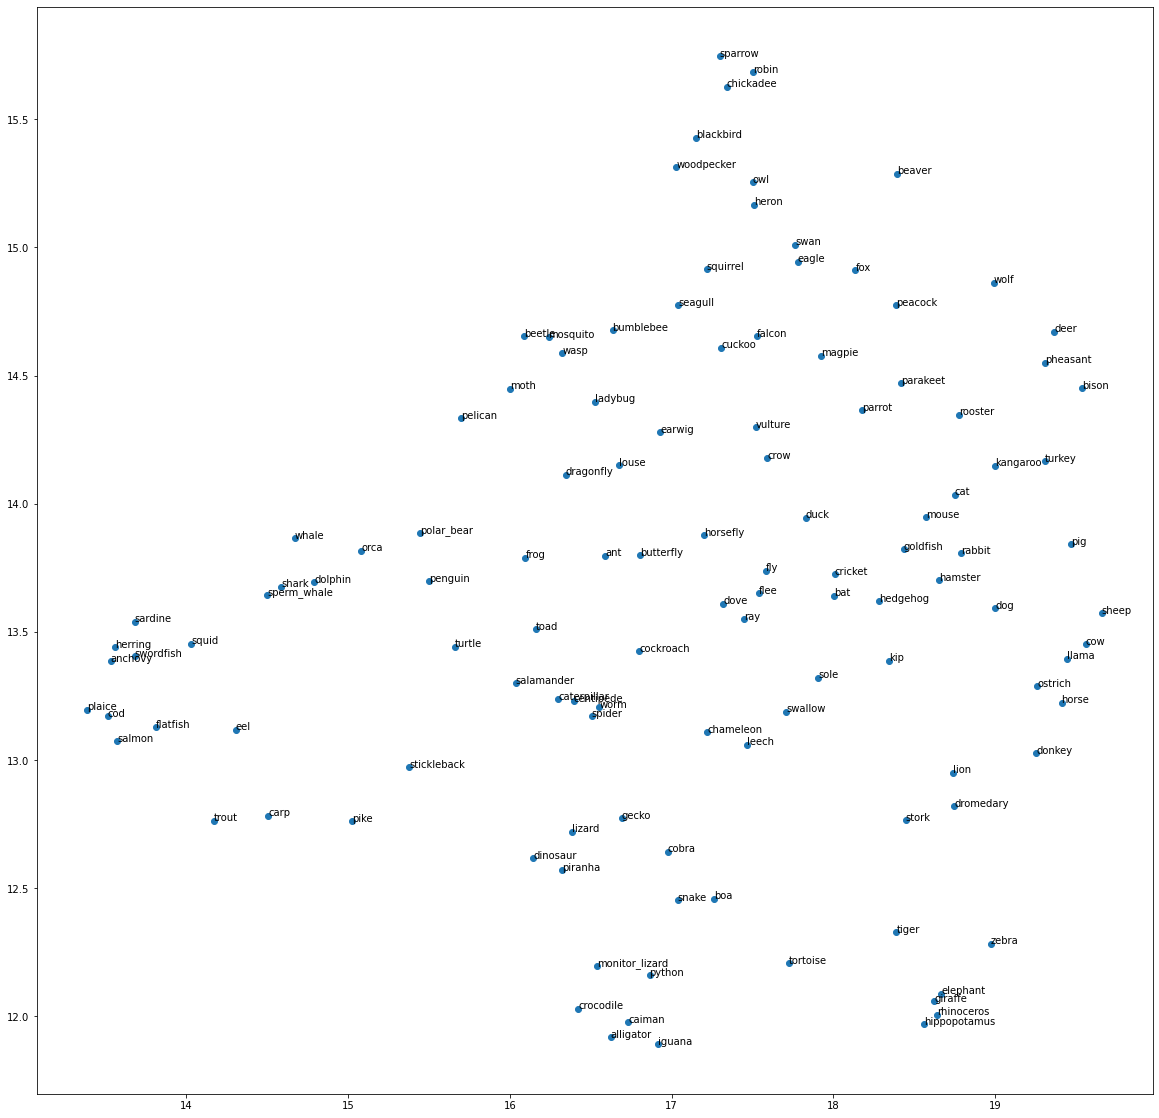

In [9]:
#Use umap to plot the word2vec representations of the animals and label them

import umap
reducer = umap.UMAP()
embedding = reducer.fit_transform(word2vec_animals)
plt.figure(figsize=(20, 20))
plt.scatter(embedding[:, 0], embedding[:, 1], marker='o')
for x, y, name in zip(embedding[:, 0], embedding[:, 1], common_words):
    plt.text(x, y, name)
plt.show()


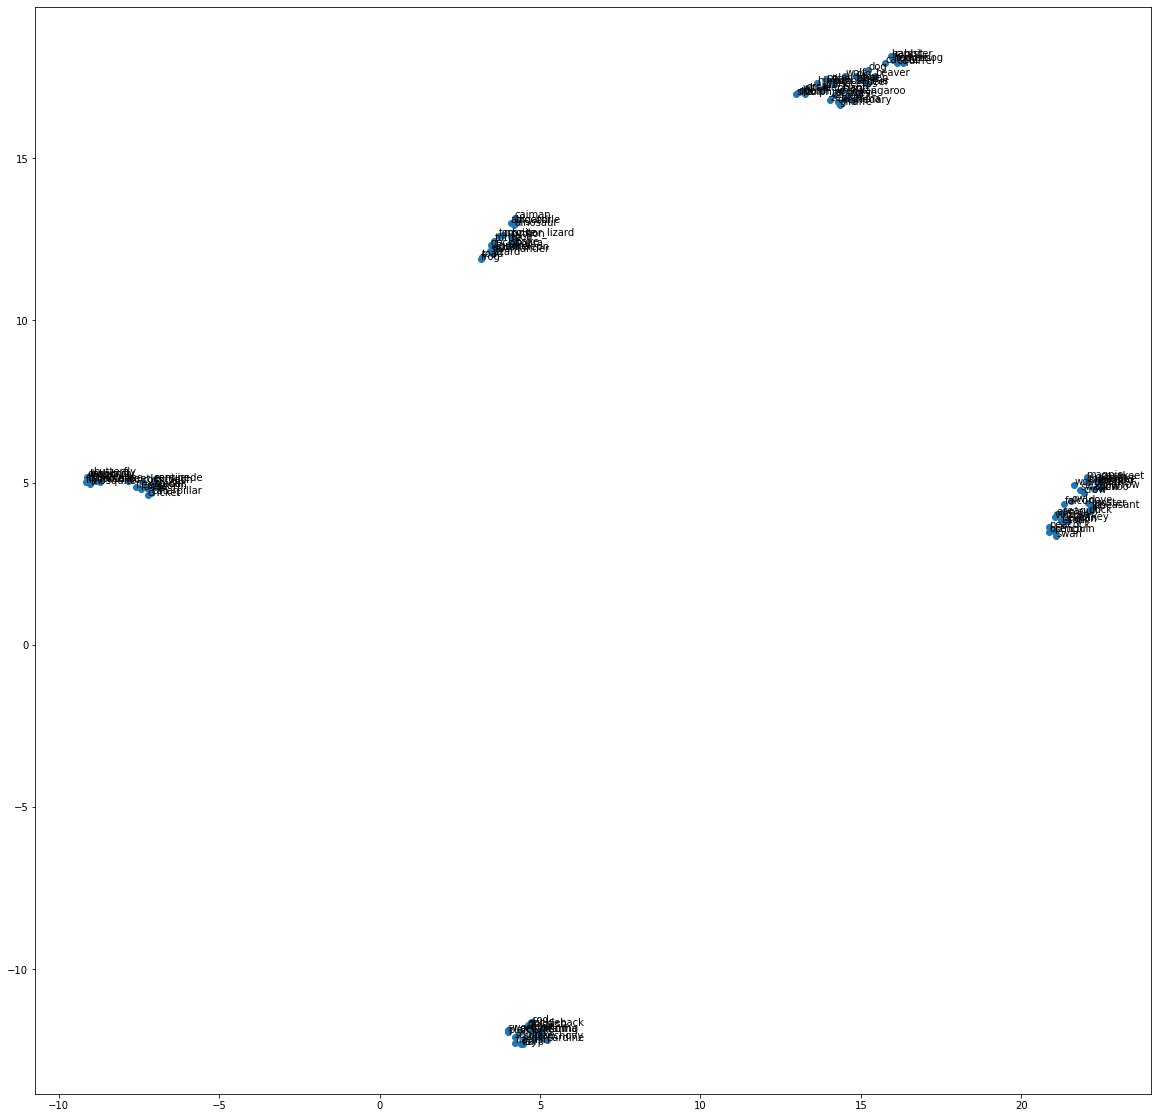

In [10]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(animal_norms_transformed)
plt.figure(figsize=(20, 20))
plt.scatter(embedding[:, 0], embedding[:, 1], marker='o')
for x, y, name in zip(embedding[:, 0], embedding[:, 1], common_words):
    plt.text(x, y, name)
plt.show()


In [13]:
word2vec_animals.shape, animal_norms_transformed.shape

((120, 300), (120, 764))

In [32]:
#see how much variance of first 10 principal components of animal norms is explained by the first 10 principal components of word2vec representations of the animals
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

pca = PCA(n_components=20)
w2v_data_rescaled = scaler.fit_transform(word2vec_animals)
pca.fit(w2v_data_rescaled)
# print(pca.explained_variance_)
word2vec_pca = pca.transform(word2vec_animals)
# word2vec_pca.shape

pca = PCA(n_components=20)
animal_norms_rescaled = scaler.fit_transform(animal_norms_transformed)
pca.fit(animal_norms_rescaled)
leuven_pca = pca.transform(animal_norms_rescaled)
# leuven_pca.shape

#see how much variance of leuvan_pca is explained by word2vec_pca usin linear regression
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(word2vec_pca, leuven_pca)
reg.score(word2vec_pca, leuven_pca)

0.42245639051268363

# Animals with attributes

In [16]:
awa_dir = '/Users/siddharthsuresh/Documents/Animals_with_Attributes2/'
awa_og = pd.read_csv(os.path.join(awa_dir,'classes.txt'), sep = "\t", header = None)


In [26]:
# get all elements in awa_og column 1 
animals_a2a = list(awa_og[1])

# replace '+' in each element in animals_a2a with '_
animals_a2a = [x.replace('+', '_') for x in animals_a2a]
len(animals_a2a)

50

In [25]:
len(animal_names)

128

In [24]:
# find the common words between animals_a2a and animal_names
common_words_a2a = set(animals_a2a).intersection(animal_names)
len(common_words_a2a)

22

In [29]:
awa_og = pd.read_csv(os.path.join(awa_dir,'predicate-matrix-binary.txt'), sep = "\t", header = None)

pca = PCA(n_components=20)
animal_norms_rescaled = scaler.fit_transform(animal_norms_transformed)
pca.fit(animal_norms_rescaled)
leuven_pca = pca.transform(animal_norms_rescaled)

In [30]:
awa_og

,0
0,0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 1 0 0 1 0 0 ...
1,1 0 0 1 0 0 0 0 0 0 0 1 0 1 1 0 1 0 0 0 0 0 1 ...
2,1 1 0 0 0 0 0 0 1 1 0 0 1 1 1 0 1 1 1 0 0 0 0 ...
3,0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 1 1 0 0 0 0 1 1 ...
4,1 1 0 0 0 0 0 0 1 1 0 1 1 0 1 0 0 1 0 0 0 0 1 ...
5,0 1 1 0 1 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 1 1 ...
6,1 1 0 1 1 0 0 0 1 0 0 1 0 1 1 0 0 1 0 0 1 0 0 ...
7,1 0 0 1 1 0 0 0 1 0 0 1 0 0 1 0 0 1 0 0 0 1 1 ...
8,0 0 1 0 1 0 0 0 0 1 0 0 1 1 1 0 1 0 1 0 0 0 0 ...
9,1 1 0 1 1 0 0 0 1 0 0 1 0 0 0 1 0 1 0 0 0 1 1 ...


# Get CLIP features

In [1]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 4.4 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-hp_cuz06
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-hp_cuz06
  Resolved https://github.com/openai/CLIP.git to commit d50d76daa670286dd6cacf3bcd80b5e4823fc8e1
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.4/776.4 MB 2.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 37.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 46.9 MB/s eta 0:00:00a 0:00:01
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369370 sha256=d2814cfd567d002c5c87c1d0927f6d700466d65287786ecec19700c81cd20be7
  Stored in directory: /tmp/pip-ephem-wheel-cache-2pkkr_t_/wheels/c8/e4/e1/11374c111387672fc2068dfbe0d4b424cb9cdd1b2e184a71b5
Successfully built clip


In [2]:
import numpy as np
import torch
from pkg_resources import packaging

print("Torch version:", torch.__version__)

Torch version: 1.12.1+cu102


/home/siddsuresh97/packages/anaconda3/envs/conceptual_represenations_gpt/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import clip
model, preprocess = clip.load("ViT-B/32")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

100%|███████████████████████████████████████| 338M/338M [00:34<00:00, 10.2MiB/s]
/home/siddsuresh97/packages/anaconda3/envs/conceptual_represenations_gpt/lib/python3.9/site-packages/torch/cuda/__init__.py:146: UserWarning: 
NVIDIA GeForce RTX 3090 with CUDA capability sm_86 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_70.
If you want to use the NVIDIA GeForce RTX 3090 GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(incompatible_device_warn.format(device_name, capability, " ".join(arch_list), device_name))


Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


In [ ]:
# text_tokens = clip.tokenize([]).cuda()